This notebook is a supplement to the paper ["The Orthologic of Epistemic Modals"](https://escholarship.org/uc/item/0ss5z8g3) by [Wesley H. Holliday](mailto:wesholliday@berkeley.edu) and [Matthew Mandelkern](mandelkern@nyu.edu). The notebook focuses on the *possibility semantics* for modal orthologic discussed in Section 4 of the paper.

# Notebook Outline

### 1. Compatibility frames

#### 1.1 The compatibility frame for the Epistemic Scale
#### 1.2 The compatibility frame for the Epistemic Grid

### 2. The ortholattice of regular sets

#### 1.1 The ortholattices from the Epistemic Scale
#### 1.2 The ortholattices from the Epistemic Grid

### 3. Hasse diagrams of the lattices

#### 3.1 Displaying the ortholattices from the Epistemic Scale
#### 3.2 Displaying the ortholattices from the Epistemic Grid

### 4. Operations on regular sets

### 5. Adding accessibility
#### 5.1 Accessibility for the Epistemic Scale
#### 5.2 Accessibility for the Epistemic Grid

In [1]:
import copy
import networkx as nx
import matplotlib.pyplot as plt

## 1. Compatibility frames

In [2]:
# when defining compatibility frames, 
# in order to avoid entering pairs (x,x) manually, we use the following:

def reflexive_closure(rel,X):
    """given a binary relation rel on X, returns the reflexive closure of rel"""
    relset = set(rel)

    for x in X:
        if not (x,x) in relset:
            rel.append((x,x))
    return rel

In [3]:
def domain(rel):
    """given a relation assumed to be reflexive, returns the domain of the relation"""
    X = {pair[0] for pair in rel}
    
    return X

In [4]:
def draw_digraph(rel,X = None):
    """given a relation rel on X, draw the digraph (with no loops) for rel;
    if no X is given, we assume rel is reflexive and take X to be the domain of rel"""
    
    if X is None:
        X = domain(rel)
    
    g = nx.DiGraph()
    g.add_nodes_from(X)
    
    for pair in rel:
        if not pair[0] == pair[1]:
            g.add_edge(pair[0],pair[1])
    
    nx.draw(g)
    plt.show() 

### 1.1 The compatibilty frame for the Epistemic Scale

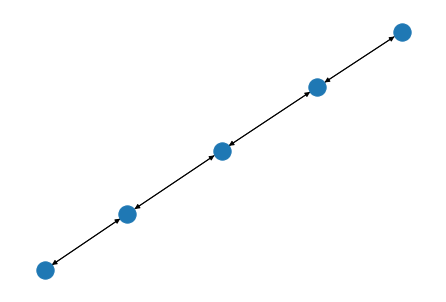

In [5]:
scale_rel = reflexive_closure([(0,1),(1,0),(1,2),(2,1),(2,3),(3,2),(3,4),(4,3)],range(5))
draw_digraph(scale_rel)

### 1.2 The compatibilty frame for the Epistemic Grid

As described in Example 4.33, the Epistemic Grid comes from the Epistemic Scale by a product construction.

In [6]:
prod = []
for x in range(5):
    for y in range (5):
        prod.append((x,y))

In [7]:
prod_rel = []
for pair in prod:
    for pair2 in prod:
        if abs(pair[0]-pair2[0])<=1 and abs(pair[1]-pair2[1])<=1: 
            prod_rel.append((pair,pair2))

In [8]:
print(prod_rel)

[((0, 0), (0, 0)), ((0, 0), (0, 1)), ((0, 0), (1, 0)), ((0, 0), (1, 1)), ((0, 1), (0, 0)), ((0, 1), (0, 1)), ((0, 1), (0, 2)), ((0, 1), (1, 0)), ((0, 1), (1, 1)), ((0, 1), (1, 2)), ((0, 2), (0, 1)), ((0, 2), (0, 2)), ((0, 2), (0, 3)), ((0, 2), (1, 1)), ((0, 2), (1, 2)), ((0, 2), (1, 3)), ((0, 3), (0, 2)), ((0, 3), (0, 3)), ((0, 3), (0, 4)), ((0, 3), (1, 2)), ((0, 3), (1, 3)), ((0, 3), (1, 4)), ((0, 4), (0, 3)), ((0, 4), (0, 4)), ((0, 4), (1, 3)), ((0, 4), (1, 4)), ((1, 0), (0, 0)), ((1, 0), (0, 1)), ((1, 0), (1, 0)), ((1, 0), (1, 1)), ((1, 0), (2, 0)), ((1, 0), (2, 1)), ((1, 1), (0, 0)), ((1, 1), (0, 1)), ((1, 1), (0, 2)), ((1, 1), (1, 0)), ((1, 1), (1, 1)), ((1, 1), (1, 2)), ((1, 1), (2, 0)), ((1, 1), (2, 1)), ((1, 1), (2, 2)), ((1, 2), (0, 1)), ((1, 2), (0, 2)), ((1, 2), (0, 3)), ((1, 2), (1, 1)), ((1, 2), (1, 2)), ((1, 2), (1, 3)), ((1, 2), (2, 1)), ((1, 2), (2, 2)), ((1, 2), (2, 3)), ((1, 3), (0, 2)), ((1, 3), (0, 3)), ((1, 3), (0, 4)), ((1, 3), (1, 2)), ((1, 3), (1, 3)), ((1, 3), 

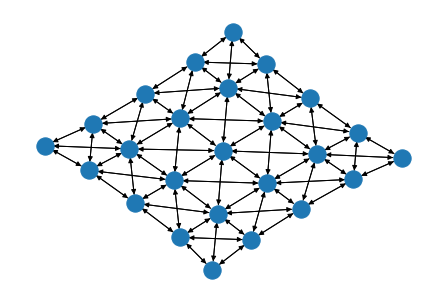

In [39]:
draw_digraph(prod_rel)

## 2. The ortholattice of regular sets

Given a compatibility frame $(S,\between)$, consider the closure operator $c_\between: \wp(S)\to \wp(S)$ defined by $c_\between(A)=\{x\in S\mid \forall y\between x\,\exists z\between y: z\in A\}$.

What we call "$\between$-regular sets" in the paper are fixpoints of $c_\between$, i.e., sets $A\subseteq S$ such that $c_\between(A)=A$.

In [10]:
def closure(A,rel,X = None):
    """given a subset A of X, returns the closure of A according to the closure operator
    defined from the compatibility relation rel as above;
    if no X is given, we assume rel is reflexive and take X to be the domain of rel"""

    if X is None:
        X = domain(rel)
    
    Aset = set(A)
    Xset = set(X)
    closure = [x for x in A]
   
    for x in Xset - Aset:
        x_sees = {y for y in X if (y,x) in rel}
        sees_into_A = {y for y in X if any([pair[0] in Aset and pair[1]==y for pair in rel])}
        if x_sees.issubset(sees_into_A):
            closure.append(x)
        
    return closure

For small compatibility frames, we can simply check for each subset whether it is a fixpoint of the closure operator.

In [11]:
def fixpoints_slow(rel,X = None):
    """given a binary relation rel on X, returns the fixpoints of the closure operator defined above"""

    if X is None:
        X = domain(rel)
    
    fixpts = [(), tuple(X)]
    
    pwrset = powerset(X)

    for A in pwrset:
        if A == () or A == tuple(X):
            continue
            
        if A == tuple(closure(A,rel,X)):
            fixpts.append(A)

    return fixpts

To handle larger compatibility frames, we can use Ganter's algorithm to calculate fixpoints of a closure operator (Ganter B. (2010), "Two Basic Algorithms in Concept Analysis." In: Kwuida L., Sertkaya B. (eds) Formal Concept Analysis. ICFCA 2010. *Lecture Notes in Computer Science*, vol 5986. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-11928-6_22). 

Ganter's algorithm assumes a closure operator on the powerset of a set $X$ where $X$ is an initial segment of the natural numbers (or otherwise linearly ordered). Thus, we include a function to convert a given compatibility frame to an isomorphic copy whose domain is an initial segment of the natural numbers.

In [12]:
def convert_to_nums(rel, X = None):
    """Given a compatibility frame, return an isomorphic copy
    whose domain is an initial segment of the natural numbers plus
    a dictionary to go back from natural numbers to the original elements"""
    
    if X is None:
        X = domain(rel)
    
    forward_map = {}
    inverse_map = {}
    count = 0
    
    for x in X:
        forward_map[x] = count
        inverse_map[count] = x
        count += 1  
    
    newrel = []
    
    for pair in rel:
        newrel.append((forward_map[pair[0]],forward_map[pair[1]]))
    
    return newrel, inverse_map

We implement the algorithm on p. 316 of Ganter's paper with the following two functions.

In [13]:
def next_fixpoint(A, rel, X = None):
    """Given a compatibility relation rel on an initial segment of the natural numbers
    and a subset A, assumed to be a fixpoint, calculate the next fixpoint
    according to Ganter's lectic ordering"""
    
    if X is None:
        X = domain(rel)
        
    Aset = set(A)
    
    for i in reversed(X):
        if not i in Aset:
            iset = set(range(i))
            inter = Aset.intersection(iset)
            union = inter.union({i})
            Anext = closure(union, rel, X)
            if [j for j in Anext if j<i and not j in Aset] == []:
                return tuple(Anext) 

In [14]:
def fixpoints(rel, X = None):
    """Given a compatibility relation rel, return the fixpoints according to Ganter's algorithm;
    if rel is not already on an initial segment of the natural numbers, 
    apply convert_to_nums in order to run next_fixpoint and then apply 
    the inverse map to get corresponding fixpoints for the original rel"""
    
    if X is None:
        X = domain(rel)
        
    if tuple(X) == tuple(range(len(X))):
        
        listX = list(X)
        tupX = tuple(X)
    
        fixpts = [set()]
        A = ()
    
        while not A == tupX:
            A_next = next_fixpoint(A,rel,listX)
            A = A_next
            fixpts.append(set(A_next))
        
        return fixpts
    
    else:
        conv = convert_to_nums(rel, X)
        newrel = conv[0]
        inverse = conv[1]
        newX = domain(newrel)
        
        listX = list(newX)
        tupX = tuple(newX)
        
        fixpts = [set()]
        A = ()
    
        while not A == tupX:
            A_next = next_fixpoint(A,newrel,listX)
            A = A_next
            A_next_inverse = tuple({inverse[a] for a in A_next})
            fixpts.append(set(A_next_inverse))
        
        return fixpts

### 2.1 The ortholattice for the Epistemic Scale

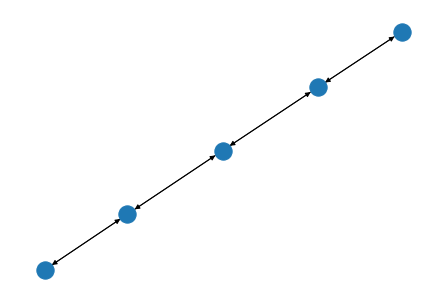

In [15]:
#Recall the compatibility frame for the Epistemic Scale
draw_digraph(scale_rel)

In [16]:
scale_lat = fixpoints(scale_rel)
print(len(scale_lat))
print(scale_lat)

10
[set(), {4}, {3, 4}, {2}, {2, 3, 4}, {0}, {0, 4}, {0, 1}, {0, 1, 2}, {0, 1, 2, 3, 4}]


### 2.2 The ortholattice for the Epistemic Grid

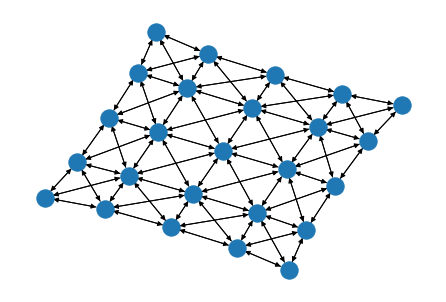

In [17]:
#Recall the compatibility frame for the Epistemic Grid
draw_digraph(prod_rel)

In [18]:
grid_lat = fixpoints(prod_rel)

In [19]:
len(grid_lat)

1942

## 3. Hasse diagrams of the lattices

Given a family of regular sets, we first calculate the proper subset relation between them, then calculate the associated covering relation, and finally create a networkx digraph for the Hasse diagram of the lattice of regular sets.

In [20]:
def propsubrel(lt):
    """given a list of tuples representing a set of sets, returns the proper subset relation as a list of pairs"""
    propsubrel = []
    
    for A in lt:
        for B in lt:  
            if set(A).issubset(set(B)) and not set(B).issubset(set(A)):
                propsubrel.append((A,B))
                
    return propsubrel

In [21]:
def covering(spo):
    """given a strict partial order spo, returns the associated covering relation"""
    cover = copy.deepcopy(spo)
    for p1 in spo:
        for p2 in spo:
            if p1 in cover and p1[0] == p2[0] and (p2[1],p1[1]) in spo:
                cover.remove(p1)
                break
    return cover

In [22]:
def lattice(regsets):
    """given a family of regular sets, returns the Hasse diagram of the lattice of regular sets"""
        
    regtuples = [tuple(A) for A in regsets]
    cover = covering(propsubrel(regtuples))
    l = nx.DiGraph()
    l.add_nodes_from(regtuples)
    l.add_edges_from(cover) 
    
    return l

### 3.1 Displaying the ortholattices from the Epistemic Scale

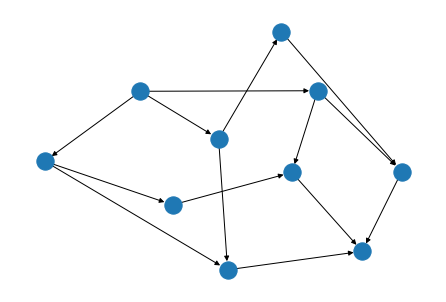

In [43]:
l = lattice(scale_lat)

nx.draw(l)
plt.show() 

### 3.1 Displaying the ortholattice from the Epistemic Grid

Unfortunately the 1,942-element ortholattice from the Epistemic Grid is too large for networkx to display.

In [24]:
#l = lattice(grid_lat)

#nx.draw(l)
#plt.show() 

## 4. Operations on regular sets

In [25]:
def neg(A,rel,X = None):
    """given a subset A of a compatibility frame with compatibility relation rel
    return the orthocomplement of A"""
    
    setA = set(A)
    
    if X is None:
        X = domain(rel)
        
    setX = set(X)
        
    negA = [x for x in setX if set([y for y in X if (y,x) in rel and y in setA]) == set()]
    
    return set(negA)

In [26]:
def wedge(A,B):
    """Given two subsets of a compatibility frame, return their conjunction (intersection)"""
    return A.intersection(B)

In [27]:
def vee(A,B,rel,X = None):
    """Given two subsets of a compatibility frame, return their disjunction (closure of union)"""
    return set(closure(A.union(B),rel))

For example, let's verify De Morgan's law in the ortholattice from the Epistemic Scale.

In [28]:
for A in scale_lat:
    for B in scale_lat:
        if not vee(A,B,scale_rel) == neg(wedge(neg(A,scale_rel),neg(B,scale_rel)), scale_rel):
            print("Violation of De Morgan's law!")

Below we give the valuation of $p$ and $q$ in the Epistemic Grid used in the paper.

In [29]:
Pset = {(0,0),(1,0),(2,0),(3,0),(4,0),(0,1),(1,1),(2,1),(3,1),(4,1)}
Qset = {(0,0),(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(1,4)}

In [30]:
Pset.intersection(Qset)

{(0, 0), (0, 1), (1, 0), (1, 1)}

In [60]:
print(neg(Pset,prod_rel))

{(4, 4), (2, 4), (0, 4), (3, 4), (4, 3), (0, 3), (1, 4), (2, 3), (3, 3), (1, 3)}


In [61]:
print(neg(Qset,prod_rel))

{(4, 4), (4, 0), (3, 4), (4, 3), (3, 1), (4, 2), (3, 0), (3, 3), (3, 2), (4, 1)}


In [62]:
print(neg(Pset.intersection(Qset),prod_rel))

{(4, 4), (2, 4), (4, 0), (0, 4), (3, 4), (4, 3), (3, 1), (4, 1), (0, 3), (4, 2), (3, 0), (1, 4), (2, 3), (3, 3), (3, 2), (1, 3)}


## 5. Adding accessibility

For modalities, in this notebook we use the accessibility relation representation instead of the accessibility function representation in order to use fewer possibilities in our frames.

In [34]:
def box(A, access, X = None):
    """given a subset A of a compatibility frame with accessibility relation access
    return Box A"""
    
    setA = set(A)
    
    if X is None:
        X = domain(access)
        
    BoxA = [x for x in setA if set([y for y in X if (x,y) in access]).issubset(setA)]
    
    return set(BoxA)

In [47]:
def diamond(A, rel, access, X = None):
    """given a subset A of a compatibility frame with accessibility relation access
    return Diamond A"""
    
    if X is None:
        X = domain(access)
    
    return neg(box(neg(A,rel),access),rel)

### 5.1 Accessibility for the Epistemic Scale

In [35]:
access_on_scale = reflexive_closure([(1,0),(1,2),(3,2),(3,4)],range(5))

The following test ensures that for every regular subset $A$ of the Epistemic Grid, $\Box A$ is also regular.

In [36]:
for A in scale_lat:
    boxA = box(A,access_on_scale)
    print(f"A is {A}")
    print(f"Box A is {boxA}")
    print("\n")

A is set()
Box A is set()


A is {4}
Box A is {4}


A is {3, 4}
Box A is {4}


A is {2}
Box A is {2}


A is {2, 3, 4}
Box A is {2, 3, 4}


A is {0}
Box A is {0}


A is {0, 4}
Box A is {0, 4}


A is {0, 1}
Box A is {0}


A is {0, 1, 2}
Box A is {0, 1, 2}


A is {0, 1, 2, 3, 4}
Box A is {0, 1, 2, 3, 4}




### 5.2 Accessibility for the Epistemic Grid

In [37]:
access_on_grid = reflexive_closure([((1,0),(0,0)), ((1,0),(2,0)), ((3,0),(2,0)), ((3,0),(4,0)),
                                    ((1,1),(0,1)), ((1,1),(2,1)), ((3,1),(2,1)), ((3,1),(4,1)),
                                    ((1,2),(0,2)), ((1,2),(2,2)), ((3,2),(2,2)), ((3,2),(4,2)),
                                    ((1,3),(0,3)), ((1,3),(2,3)), ((3,3),(2,3)), ((3,3),(4,3)),
                                    ((1,4),(0,4)), ((1,4),(2,4)), ((3,4),(2,4)), ((3,4),(4,4)),
                                    
                                    ((0,1),(0,0)), ((0,1),(0,2)), ((0,3),(0,2)), ((0,3),(0,4)),
                                    ((1,1),(1,0)), ((1,1),(1,2)), ((1,3),(1,2)), ((1,3),(1,4)),
                                    ((2,1),(2,0)), ((2,1),(2,2)), ((2,3),(2,2)), ((2,3),(2,4)),
                                    ((3,1),(3,0)), ((3,1),(3,2)), ((3,3),(3,2)), ((3,3),(3,4)),
                                    ((4,1),(4,0)), ((4,1),(4,2)), ((4,3),(4,2)), ((4,3),(4,4)),
                                    
                                    ((1,1),(0,0)), ((1,1),(2,0)), ((1,1),(2,2)), ((1,1),(0,2)),
                                    ((3,1),(2,0)), ((3,1),(2,2)), ((3,1),(4,2)), ((3,1),(4,0)),
                                    ((1,3),(0,2)), ((1,3),(0,4)), ((1,3),(2,4)), ((1,3),(2,2)),
                                    ((3,3),(2,2)), ((3,3),(4,2)), ((3,3),(4,4)), ((3,3),(2,4))], 
                                   
                                   prod)

The following test ensures that for every regular subset $A$ of the Epistemic Grid, $\Box A$ is also regular.

In [38]:
for A in grid_lat:
    boxA = box(A,access_on_grid)
    if boxA not in grid_lat:
        print("Box of this regular set is not regular!")
        print(fx)
        print(boxfx)
        print("\n")

We now calculate the truth values of some formulas using the valuation for $p$ and $q$ on the Epistemic Grid.

In [44]:
#Recall the valuation of p and q on the Epistemic Grid

Pset = {(0,0),(1,0),(2,0),(3,0),(4,0),(0,1),(1,1),(2,1),(3,1),(4,1)}
Qset = {(0,0),(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(1,4)}

In [55]:
diamond_P = diamond(Pset,prod_rel,access_on_grid)
print(diamond_P)

{(0, 1), (1, 2), (4, 0), (2, 1), (0, 0), (3, 1), (1, 1), (2, 0), (4, 2), (3, 0), (0, 2), (2, 2), (1, 0), (3, 2), (4, 1)}


In [56]:
diamond_Q = diamond(Qset,prod_rel,access_on_grid)
print(diamond_Q)

{(0, 1), (2, 4), (1, 2), (0, 4), (2, 1), (0, 0), (1, 1), (0, 3), (2, 0), (1, 4), (2, 3), (0, 2), (2, 2), (1, 0), (1, 3)}


In [58]:
print(wedge(diamond_P,diamond_Q))

{(0, 1), (1, 2), (2, 1), (0, 0), (1, 1), (2, 0), (0, 2), (2, 2), (1, 0)}


In [63]:
print(diamond(wedge(Pset,Qset),prod_rel,access_on_grid))

{(0, 1), (1, 2), (2, 1), (0, 0), (1, 1), (2, 0), (0, 2), (2, 2), (1, 0)}


In the paper we consider cutting the accessibility arrow from the point (3,3) to the center point.

In [65]:
access_on_grid2 = reflexive_closure([((1,0),(0,0)), ((1,0),(2,0)), ((3,0),(2,0)), ((3,0),(4,0)),
                                    ((1,1),(0,1)), ((1,1),(2,1)), ((3,1),(2,1)), ((3,1),(4,1)),
                                    ((1,2),(0,2)), ((1,2),(2,2)), ((3,2),(2,2)), ((3,2),(4,2)),
                                    ((1,3),(0,3)), ((1,3),(2,3)), ((3,3),(2,3)), ((3,3),(4,3)),
                                    ((1,4),(0,4)), ((1,4),(2,4)), ((3,4),(2,4)), ((3,4),(4,4)),
                                    
                                    ((0,1),(0,0)), ((0,1),(0,2)), ((0,3),(0,2)), ((0,3),(0,4)),
                                    ((1,1),(1,0)), ((1,1),(1,2)), ((1,3),(1,2)), ((1,3),(1,4)),
                                    ((2,1),(2,0)), ((2,1),(2,2)), ((2,3),(2,2)), ((2,3),(2,4)),
                                    ((3,1),(3,0)), ((3,1),(3,2)), ((3,3),(3,2)), ((3,3),(3,4)),
                                    ((4,1),(4,0)), ((4,1),(4,2)), ((4,3),(4,2)), ((4,3),(4,4)),
                                    
                                    ((1,1),(0,0)), ((1,1),(2,0)), ((1,1),(2,2)), ((1,1),(0,2)),
                                    ((3,1),(2,0)), ((3,1),(2,2)), ((3,1),(4,2)), ((3,1),(4,0)),
                                    ((1,3),(0,2)), ((1,3),(0,4)), ((1,3),(2,4)), ((1,3),(2,2)),
                                                   ((3,3),(4,2)), ((3,3),(4,4)), ((3,3),(2,4))], 
                                   
                                   prod)

The following test ensures that for every regular subset $A$ of the modified Epistemic Grid, $\Box A$ is also regular.

In [66]:
for A in grid_lat:
    boxA = box(A,access_on_grid2)
    if boxA not in grid_lat:
        print("Box of this regular set is not regular!")
        print(fx)
        print(boxfx)
        print("\n")

In [67]:
diamond_P2 = diamond(Pset,prod_rel,access_on_grid2)
print(diamond_P2)

{(0, 1), (1, 2), (4, 0), (2, 1), (0, 0), (3, 1), (1, 1), (2, 0), (4, 2), (3, 0), (0, 2), (2, 2), (1, 0), (3, 2), (4, 1)}


In [68]:
diamond_Q2 = diamond(Qset,prod_rel,access_on_grid2)
print(diamond_Q2)

{(0, 1), (2, 4), (1, 2), (0, 4), (2, 1), (0, 0), (1, 1), (0, 3), (2, 0), (1, 4), (2, 3), (0, 2), (2, 2), (1, 0), (1, 3)}


In [69]:
print(wedge(diamond_P2,diamond_Q2))

{(0, 1), (1, 2), (2, 1), (0, 0), (1, 1), (2, 0), (0, 2), (2, 2), (1, 0)}


In [70]:
print(diamond(wedge(Pset,Qset),prod_rel,access_on_grid2))

{(0, 1), (1, 2), (2, 1), (0, 0), (1, 1), (2, 0), (0, 2), (1, 0)}


Thus, as stated in the paper, now $\Diamond(p\wedge q)$ is no longer true at the center point $(2,2)$.